# Generalization with OOP: An SMA Backtesting Class in Action
Part 127

Question:
- What is outperformance (cumulative_returns)

## Create Backtester Class

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

class SMABacktester():
    def __init__(self, symbol:str, sma_s:int, sma_l:int, start:str, end:str):
        self.symbol = symbol
        self.sma_s = sma_s
        self.sma_l = sma_l
        self.start = start
        self.end = end
        self.get_data()
        
    def get_data(self):
        # Getting the dataframe, drop and rename
        raw = pd.read_csv("data/forex_pairs.csv", parse_dates=["Date"], index_col="Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end,:].copy()
        raw.rename(columns={self.symbol:"price"}, inplace=True)
        raw["returns"] = np.log(raw/raw.shift(1))
        self.data = raw
        
    def prepare_data(self):
        data = self.data.copy()
        data["sma_s"] = data["price"].rolling(self.sma_s).mean()
        data["sma_l"] = data["price"].rolling(self.sma_l).mean()
        self.data = data
    
    def set_parameters(self, sma_s_input=None, sma_l_input=None):
        if sma_s_input is not None:
            self.sma_s = sma_s_input
            self.data["sma_s"] = self.data["price"].rolling(self.sma_s).mean()
        if sma_l_input is not None:
            self.sma_l = sma_l_input
            self.data["sma_l"] = self.data["price"].rolling(self.sma_l).mean()
            
    def test_strategy(self):
        data = self.data.copy().dropna()
        data["position"] = np.where(data["sma_s"] > data["sma_l"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        data["cumu_returns"] = data["returns"].cumsum().apply(np.exp)
        data["cumu_strategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        # Finding the absolute performance - the bottom of the cumulative strategy
        perf = data["cumu_strategy"].iloc[-1]
        # Finding out performance
        out_perf = perf - data["cumu_returns"].iloc[-1]
        return round(perf, 4), round(out_perf, 4)
    
    def plot_results(self):
        if self.results is None:
            print("Run test_strategy() before plotting the result")
        else:
            title = f"{self.symbol} - SMA_S:{self.sma_s}|SMA_L:{self.sma_l}"
            self.results[["cumu_returns", "cumu_strategy"]].plot(figsize=(10,7), title=title)
            
    def optimize_parameters(self, sma_s_range, sma_l_range):
        combinations = list(product(range(*sma_s_range), range(*sma_l_range)))
        
        # Test all combinations
        results = []
        for comb in combinations:
            self.set_parameters(comb[0], comb[1])
            results.append(self.test_strategy()[0])
            
        # Find best performance and index of best performance
        best_perf = np.max(results) # best performance
        opt_perf_idx = combinations[np.argmax(results)] # Index of the best performance
        
        # Run/Set the optimal strategy
        self.set_parameters(opt_perf_idx[0], opt_perf_idx[1])
        self.test_strategy()
        
        # Create a df with many results
        df_results = pd.DataFrame(data = combinations, columns=["sma_s","sma_l"])
        df_results["performance"] = results
        self.results_overview = df_results
            
        return opt_perf_idx, best_perf
    
    def find_best(self, num_row:int=5):
        return self.results_overview.nlargest(num_row, "performance")

In [38]:
tester = SMABacktester("AUDEUR=X", 50, 200, "2010-01-01", "2019-12-31")

tester.data

,price,returns
Date,,
2010-01-01,0.62402,NaN
2010-01-04,0.63230,0.013182
2010-01-05,0.63430,0.003158
2010-01-06,0.63860,0.006756
2010-01-07,0.64060,0.003127
...,...,...
2019-12-25,0.62410,-0.000240
2019-12-26,0.62380,-0.000481
2019-12-27,0.62550,0.002722


In [39]:
tester.set_parameters(30,120)
tester.data

,price,returns,sma_s,sma_l
Date,,,,
2010-01-01,0.62402,NaN,NaN,NaN
2010-01-04,0.63230,0.013182,NaN,NaN
2010-01-05,0.63430,0.003158,NaN,NaN
2010-01-06,0.63860,0.006756,NaN,NaN
2010-01-07,0.64060,0.003127,NaN,NaN
...,...,...,...,...
2019-12-25,0.62410,-0.000240,0.616969,0.615853
2019-12-26,0.62380,-0.000481,0.617058,0.615938
2019-12-27,0.62550,0.002722,0.617378,0.616047


In [40]:
tester.test_strategy()

(0.6727, -0.2196)

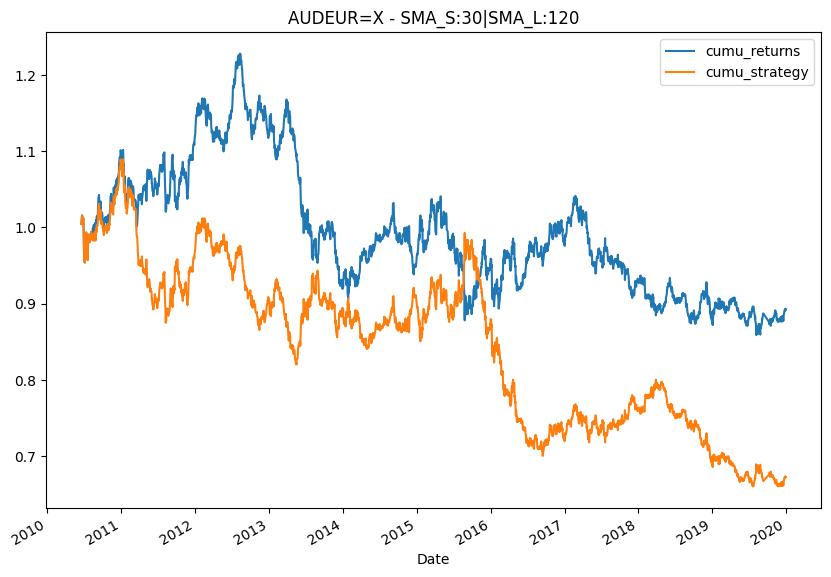

In [41]:
tester.plot_results()

In [42]:
tester.optimize_parameters((10,50,1),(100,252,1))

((32, 199), 1.2178)

In [43]:
tester.results_overview

,sma_s,sma_l,performance
0,10,100,0.7061
1,10,101,0.6769
2,10,102,0.6930
3,10,103,0.6794
4,10,104,0.6874
...,...,...,...
6075,49,247,1.0273
6076,49,248,1.0268
6077,49,249,1.0277
6078,49,250,1.0370


In [44]:
tester.find_best()

,sma_s,sma_l,performance
3443,32,199,1.2178
3442,32,198,1.1922
3748,34,200,1.1804
3593,33,197,1.1764
3591,33,195,1.1735


# Testing

In [53]:
sma_s = 32
sma_l = 199

df = pd.read_csv("data/forex_pairs.csv", parse_dates=["Date"], index_col="Date")
df = df["AUDEUR=X"].to_frame()
df.rename(columns={"AUDEUR=X":"price"}, inplace=True)
df.head()

,price
Date,
2004-01-01,0.59780
2004-01-02,0.60314
2004-01-05,0.60467
2004-01-06,0.60350
2004-01-07,0.60728


In [54]:
df["sma_s"] = df["price"].rolling(sma_s).mean()
df["sma_l"] = df["price"].rolling(sma_l).mean()
df.dropna(inplace=True)

df

,price,sma_s,sma_l
Date,,,
2004-10-05,0.58758,0.577535,0.594875
2004-10-06,0.58796,0.577588,0.594825
2004-10-07,0.59147,0.577828,0.594766
2004-10-08,0.59207,0.578100,0.594703
2004-10-11,0.59252,0.578458,0.594648
...,...,...,...
2019-09-04,0.61620,0.611902,0.623343
2019-09-05,0.61590,0.611549,0.623208
2019-09-06,0.61730,0.611237,0.623044


In [56]:
df["position"] = np.where(df["sma_s"] > df["sma_l"],1,-1)
df

,price,sma_s,sma_l,position
Date,,,,
2004-10-05,0.58758,0.577535,0.594875,-1
2004-10-06,0.58796,0.577588,0.594825,-1
2004-10-07,0.59147,0.577828,0.594766,-1
2004-10-08,0.59207,0.578100,0.594703,-1
2004-10-11,0.59252,0.578458,0.594648,-1
...,...,...,...,...
2019-09-04,0.61620,0.611902,0.623343,-1
2019-09-05,0.61590,0.611549,0.623208,-1
2019-09-06,0.61730,0.611237,0.623044,-1


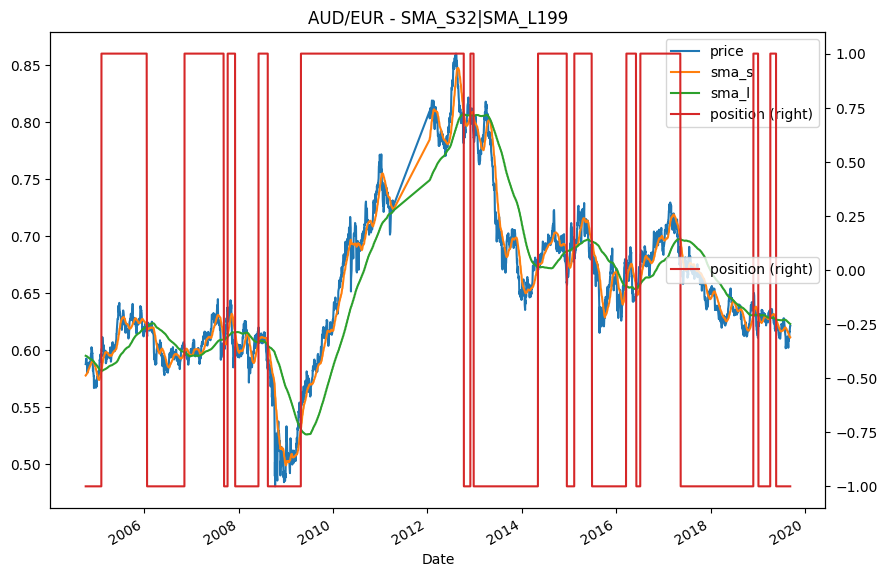

In [58]:
df.plot(figsize=(10,7), title=f"AUD/EUR - SMA_S{sma_s}|SMA_L{sma_l}", secondary_y="position")
plt.legend();

## Backtesting

In [66]:
dft = df.copy()

In [67]:
dft["returns"] = np.log(dft["price"].div(dft["price"].shift(1)))
dft["strategy"] = dft["position"].shift(1) * dft["returns"]
dft.dropna(inplace=True)
dft

,price,sma_s,sma_l,position,returns,strategy
Date,,,,,,
2004-10-06,0.58796,0.577588,0.594825,-1,0.000646,-0.000646
2004-10-07,0.59147,0.577828,0.594766,-1,0.005952,-0.005952
2004-10-08,0.59207,0.578100,0.594703,-1,0.001014,-0.001014
2004-10-11,0.59252,0.578458,0.594648,-1,0.000760,-0.000760
2004-10-12,0.59154,0.578660,0.594569,-1,-0.001655,0.001655
...,...,...,...,...,...,...
2019-09-04,0.61620,0.611902,0.623343,-1,0.006839,-0.006839
2019-09-05,0.61590,0.611549,0.623208,-1,-0.000487,0.000487
2019-09-06,0.61730,0.611237,0.623044,-1,0.002271,-0.002271


### Absolute performance

In [69]:
dft[["returns","strategy"]].sum()

returns     0.055786
strategy    0.320426
dtype: float64

### Annualized return

In [70]:
dft[["returns","strategy"]].sum() *252

returns     14.057960
strategy    80.747446
dtype: float64

### Annualized risk

In [ ]:
dft[["returns"]]